In [1]:
import tensorflow as tf

import numpy as np
import os
import time
import re
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu

Подгружаем библиотеку для оценки сгенерированного текста - https://pypi.org/project/language-tool-python/#description

In [2]:
pip install --upgrade language_tool_python

In [3]:
import language_tool_python
tool = language_tool_python.LanguageTool('ru-RU')  # use a local server (automatically set up), language English

Unzipping /tmp/tmpa1n8c32t.zip to /root/.cache/language_tool_python.
Downloaded https://www.languagetool.org/download/LanguageTool-5.1.zip to /root/.cache/language_tool_python.


Импорт данных

In [223]:
text = open("./text_with_dot.txt", 'rb').read().decode(encoding='utf-8')

In [224]:
print(text[:500])

 Трудно поверить, но Новый год уже через месяц! Рассказываем, где купить подарки — и как вдобавок помочь благотворительным фондам (им это сейчас особенно нужно). nan.  Овощи и зелень убираем вниз, готовую еду — наверх. И еще 7 советов тем, кто хочет навести порядок в холодильнике.  Как закупаться на распродажах осознанно. Чтобы и удовольствие получить, и в плюсе остаться.  Вице-мэр Новосибирска показала макет городского катка. Раньше он выглядел как пенис. Да и сейчас тоже. nan.  В пустыне Юты н


Загружаем тестовые данные на которых будем проверять метрики

In [176]:
df_test = pd.read_csv('test_data.csv')

Очищаем данные

In [225]:
def text_clear(text):
  result = text.lower()
  result = re.sub(r'[!?]', '.', result)
  result = re.sub(r'[^а-яa-z\.\-\,]', ' ', result)
  result = re.sub(r"[\|/]", '', result) 
  result = re.sub(r"[\n]", ' ', result) 
  result = re.sub(r"[\r]", ' ', result) 
  result = re.sub(r"[nan]", ' ', result) 
  result = re.sub(r'\s+', ' ', result)
  result = re.sub(r' \.', '.', result)
  result = re.sub(r'\. \.', '.', result)
  result = re.sub(r'\.\.', '.', result)
  return result

text = text_clear(text)
len(text)

6804035

In [226]:
print(text[:500])

 трудно поверить, но новый год уже через месяц. рассказываем, где купить подарки и как вдобавок помочь благотворительным фондам им это сейчас особенно нужно. овощи и зелень убираем вниз, готовую еду наверх. и еще советов тем, кто хочет навести порядок в холодильнике. как закупаться на распродажах осознанно. чтобы и удовольствие получить, и в плюсе остаться. вице-мэр новосибирска показала макет городского катка. раньше он выглядел как пенис. да и сейчас тоже. в пустыне юты нашли таинственный мета


Создаем список символов

In [227]:
# The unique characters in the file
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

60 unique characters


Формируем словари для кодирования символов

In [228]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [229]:
print('{')
for char,_ in zip(char2idx, range(10)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  ' ' :   0,
  ',' :   1,
  '-' :   2,
  '.' :   3,
  'b' :   4,
  'c' :   5,
  'd' :   6,
  'e' :   7,
  'f' :   8,
  'g' :   9,
  ...
}


Добавляем в датасет tf

In [230]:
# The maximum length sentence we want for a single input in characters
seq_length = 256
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

 
т
р
у
д


In [231]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

' трудно поверить, но новый год уже через месяц. рассказываем, где купить подарки и как вдобавок помочь благотворительным фондам им это сейчас особенно нужно. овощи и зелень убираем вниз, готовую еду наверх. и еще советов тем, кто хочет навести порядок в хол'
'одильнике. как закупаться на распродажах осознанно. чтобы и удовольствие получить, и в плюсе остаться. вице-мэр новосибирска показала макет городского катка. раньше он выглядел как пенис. да и сейчас тоже. в пустыне юты нашли таинственный металлический обел'
'иск. почти такой же, как в космической одиссее стэнли кубрика. пермь поражена коми-пермяцким вирусом, который обращает людей в зомби. спасти город может только колян. вышел трейлер абсурдной комедии реальные пацаны против зомби. как успокоить морского ежа. '
'напечатать ему шляпку на d-принтере.. житель колпино, захвативший шестерых детей, сдался полиции. в колпино отец шести детей заперся с ними в квартире и угрожает их убить. в челябинске сгорел автомобиль журналистки z k.

In [232]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

Здесь достаточно странный момент, вроде как по структуре сети мы получаем на выходе одну букву, а тут target состоит из текста, следовательно сеть, как объект, как-то по особому обрабатывает такую структуру данных. Это меня застопорило, чтобы сделать решение с несколькими словами. Но, насколько я сейчас понимаю, tf здесь работает как потоковый обработчик для всей строки в целом, то есть берется первая буква из первой строки, на выходе должна быть первая буква из второй строки и так далее вся строка обрабатывается разом

In [234]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  ' трудно поверить, но новый год уже через месяц. рассказываем, где купить подарки и как вдобавок помочь благотворительным фондам им это сейчас особенно нужно. овощи и зелень убираем вниз, готовую еду наверх. и еще советов тем, кто хочет навести порядок в хо'
Target data: 'трудно поверить, но новый год уже через месяц. рассказываем, где купить подарки и как вдобавок помочь благотворительным фондам им это сейчас особенно нужно. овощи и зелень убираем вниз, готовую еду наверх. и еще советов тем, кто хочет навести порядок в хол'


Разделение на части датасета для одновременного использования gpu

In [235]:
# Batch size
BATCH_SIZE = 512

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 50000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((512, 256), (512, 256)), types: (tf.int64, tf.int64)>

Настройки, рассчитываем размер словаря и параметры кодирования, а также настройки слоев

In [250]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 512
# Number of RNN units
rnn_units_first = 1024
rnn_units_second = 1024

Функция построения модели

In [251]:
def build_model(vocab_size, embedding_dim, rnn_units_first, rnn_units_second, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units_first,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.LSTM(rnn_units_second,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(embedding_dim),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

Создаем модель

In [252]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units_first=rnn_units_first,
  rnn_units_second=rnn_units_second,
  batch_size=BATCH_SIZE)

In [256]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (512, None, 512)          30720     
_________________________________________________________________
lstm_26 (LSTM)               (512, None, 1024)         6295552   
_________________________________________________________________
lstm_27 (LSTM)               (512, None, 1024)         8392704   
_________________________________________________________________
dense_26 (Dense)             (512, None, 512)          524800    
_________________________________________________________________
dense_27 (Dense)             (512, None, 60)           30780     
Total params: 15,274,556
Trainable params: 15,274,556
Non-trainable params: 0
_________________________________________________________________


Функция потерь, используем кроссэнтропию

In [1]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

Компилируем модель и указываем метод который будет использоваться при обучении

In [260]:
model.compile(optimizer='adam', loss=loss)

Определяем функции, которые будут выполняться во время работы модели, на определенные события - это один стандартный, который будет сохранять модель после эпохи и второй, кастомный, который будет проверять две метрики(bleu и число ошибок после проверки библиотекой, основанной на правилах)

In [261]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")


checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

class CheckCallback(tf.keras.callbacks.Callback):
    def __init__(self):
      super(MyCustomCallback, self).__init__()
      self.df_test_array_summary = pd.DataFrame()  # summary
      self.df_test_array = pd.DataFrame()  # texts

    def on_epoch_end(self, epoch, logs=None):
        model_last = build_model(vocab_size, embedding_dim, rnn_units_first, rnn_units_second, batch_size=1)
        model_last.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
        model_last.build(tf.TensorShape([1, None]))
        bleu_score_result = test_model_function(df_test, model_last, epoch, self.df_test_array)
        self.df_test_array = bleu_score_result[0]
        self.df_test_array_summary = self.df_test_array_summary.append({'epoch':epoch, 'bleu_score_mean':bleu_score_result[1], 'error_count_mean':bleu_score_result[2], 'loss_in_training':logs["loss"]},ignore_index=True)

Определим функции генерации текста

In [285]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 100
  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature =  0.5

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      #predicted_id = np.argmax(predictions[0])

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

      # break if we have a '.'
      if(text_generated == '.'):
        break

  return (start_string + ''.join(text_generated))

Функция тестирования проводит цикл по массиву тестовых данных(пару дней новостей и сохраняет информацию на каждой эпохе)

In [317]:
def test_model_function(df_test, model, epoch, df_test_array):
  # bleu score
  sum_score = 0
  # error score
  sum_error_count = 0
  count = 0
  for index, row in df_test.iterrows():
    test_text = text_clear(row['title'])
    test_text_split = test_text.split(' ')
    if len(test_text_split) > 0 and (len(test_text_split[0]) > 0):

      # generate
      result_generate = generate_text(model, start_string=str(test_text_split[0]))

      #bleu
      score = sentence_bleu(test_text_split, result_generate.split())

      # check for error
      errors_in_generate_phrase = tool.check(result_generate)

      sum_score += score
      sum_error_count += len(errors_in_generate_phrase)
      count += 1

      # write to test array
      df_test_array = df_test_array.append({'reference':test_text,'generate':result_generate,'bleu_score':score,'epoch':epoch,'lang_error':len(errors_in_generate_phrase), 'errors':errors_in_generate_phrase},ignore_index=True)

  return [df_test_array, (sum_score / count), (sum_error_count / count)]
  

Учим модель

In [ ]:
EPOCHS=20

history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
51/51 [==============================] - 187s 4s/step - loss: 0.2215
Epoch 2/20
51/51 [==============================] - 191s 4s/step - loss: 0.2224
Epoch 3/20
 9/51 [====>.........................] - ETA: 2:23 - loss: 0.2134

Используем коллбек для получения также метрик модели(требуется много времени, на получение предсказаний и вычисление метрик)

In [ ]:
#EPOCHS=20

#callback_training = CheckCallback()
#history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback,callback_training])

Можем поглядеть качество обучения

In [313]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    loss = history.history['loss']
    x = range(1, len(loss) + 1)

    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.title('Training and validation loss')
    plt.legend()


No handles with labels found to put in legend.


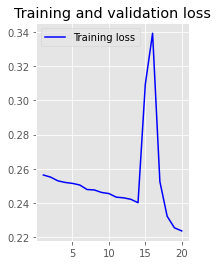

In [323]:
plot_history(history)

Примеры результатов метрик (общие выводы должны будут написаны в файле readme)

в кратце df_test_array содержит метрики для каждой строки в тестовом наборе, df_test_array_summary усредненное для всей эпохи. Разуменее всего смотреть на df_test_array_summary, конкретнее на поля error_count_mean(среднее число ошибок) и bleu_score_mean(метрика bleu для сгенерированных предсказаний)

In [36]:
callback_training.df_test_array

bleu_score  ...                                          reference
0      0.526640  ...  сколько нужно ходить, чтобы не болеть. а бегат...
1      0.488923  ...  в сингапуре голодный кабан устроил гоп-стоп. о...
2      0.478974  ...  сноуден уже постит мемы про наташу, котов и со...
3      0.485492  ...  американка выкрала из римского музея кусок мра...
4      0.417226  ...  грустить после рождения ребенка это нормально....
..          ...  ...                                                ...
420    0.386097  ...  шесть дней назад в приморье прошел ледяной дож...
421    0.475873  ...  мэрия москвы заказала непрерывный мониторинг а...
422    0.502639  ...  алтайский край один из лидеров по росту смертн...
423    0.562341  ...  ужасно хочется, чтобы вторая волна скорее зако...
424    0.461737  ...  даниил усыновил подростка, переехал в эстонию ...

[425 rows x 6 columns]

In [37]:
callback_training.df_test_array_summary

bleu_score_mean  epoch  error_count_mean  loss_in_training
0         0.379506    0.0         36.647059          3.387042
1         0.487435    1.0         37.976471          2.939065
2         0.476660    2.0         33.400000          2.633348
3         0.502333    3.0         33.741176          2.414436
4         0.455558    4.0         31.458824          2.210891

Записываем результаты исследования

In [286]:
callback_training.df_test_array.to_csv('encode_512_model_1024_1024_ltsm_text_part_5.csv')
callback_training.df_test_array_summary.to_csv('encode_512_model_1024_1024_ltsm_sumary_5.csv')

Сохраняем модель (вес в байтах)

In [324]:
model.save_weights('test_model_for_docker_weights_120')
statinfo = os.stat('test_model_for_docker_weights_120.data-00000-of-00001')
statinfo.st_size

183300079